# Generative Adversarial Networks

GANs are a novel Neural Network architecture which are designed to emulate the distribution of a given dataset.

The key concept behind these networks is that there are two neural nets employed as opposed to the usual one. **The first network** is a generator network, which takes in a random vector, and converts that into a different distribution. It is designed such that if $z\sim Unif(-1,1)$ and $z\in\mathcal{R}^d$, $G(z)\sim p(X)$ where $p(X)$ is the data distribution and $G(\cdot)$ is the generator network.

**The second network** is a binary classifier network that we are used to. It takes in a vector and classifies if the data is 'real' or 'fake'. At a certain point if the generator is powerful enough it will not be able to distinguish between the two classes and give each a probability of 0.5.

It is trained in a cat and mouse kind of way in the sense that we train the generator and then the discriminator and keep repeating. It can be rather unstable hence we employ batch normalisation and leaky relu rather heavily. Finally the GAN paper shows that in theory GANs do reach equilibrium and will converge to the true data distribution.

Personally what I find fascinating is that it is such a simple idea to use two networks (atleast when written down), but yet so powerful.

## Reference
1. GAN paper: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
!pip install tqdm

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, LeakyReLU, Activation
from keras.activations import sigmoid
import tensorflow as tf

from utilities import show_graph

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

/home/iss-user/anaconda3/envs/iss-env-py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
mnist = input_data.read_data_sets('./data', one_hot=False)
image_size = (28, 28, 1)
def plot_sample(imgs):
    sample_imgs = imgs[:9]
    plt.figure(figsize=(12,12))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(sample_imgs[i].squeeze(), cmap='gray')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [5]:
batch_size = 128
z_dim = 100
image_height = 28
image_width = 28
n_channels = 1

In [6]:
leaky_relu = lambda x: tf.maximum(x, 0.1 * x)

def upsample(x, depth, is_train, strides=2, activation=leaky_relu):
    x = tf.layers.conv2d_transpose(x, depth, 5, padding='same', strides=strides)
    x = tf.layers.batch_normalization(x, training=is_train)
    x = activation(x)
    return x, int(depth/2)

def generator(z, n_channels, is_train):
    with tf.variable_scope('generator', reuse=not is_train):
        depth = 64

        generator = tf.layers.dense(z, 7*7*depth)
        generator = tf.layers.batch_normalization(generator, training=is_train)
        generator = leaky_relu(generator)

        generator = tf.reshape(generator, (-1, 7, 7, depth))
        generator, depth = upsample(generator, depth, is_train, strides=2)
        generator, depth = upsample(generator, depth, is_train, strides=1)
        generator, depth = upsample(generator, depth, is_train, strides=1)
        generator, _ = upsample(generator, n_channels, is_train, strides=2, activation=tf.tanh)
        
        return generator

In [7]:
def conv_layer(x, depth, is_train, is_bn=True, strides=2, activation=leaky_relu):
    x = tf.layers.conv2d(x, filters=depth, kernel_size=5, strides=strides, padding='same')
    if is_bn:
        x = tf.layers.batch_normalization(x, training=is_train)
    x = activation(x)
    return x, depth*2

def discriminator(images, is_train, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        depth = 32
        
        discriminator, depth = conv_layer(images, depth, is_train, is_bn=False)
        discriminator, _ = conv_layer(discriminator, depth, is_train)
        
        discriminator = tf.reshape(discriminator, (-1, 7*7*depth))
        logits = tf.layers.dense(discriminator, 1)
        
        return logits

Network:

In [8]:
def network(input_z, input_real, n_channels, is_train):
    d_labels = tf.stack([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))])
    learning_rate = 1e-3

    inputs_fake = generator(input_z, n_channels, is_train)
    d_logits_fake = discriminator(inputs_fake, is_train)
    d_logits_real = discriminator(input_real, is_train, reuse=True)

    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.stack([d_logits_fake, d_logits_real]), 
                                                                    labels=d_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake))) 
    
    return d_loss, g_loss

def optimization(d_loss, g_loss):
    learning_rate = 1e-3
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_trainer = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_trainer = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

    return d_trainer, g_trainer

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Tensor where we will feed the data into graph
z = tf.placeholder(tf.float32, (None, z_dim), 'z')
images = tf.placeholder(tf.float32, (None, image_width, image_height, n_channels), 'images')

d_loss, g_loss = network(z, images, 1, is_train=True)
d_trainer, g_trainer = optimization(d_loss, g_loss)

In [10]:
show_graph(tf.get_default_graph().as_graph_def())

In [11]:
def show_images(gen_im):
    plt.figure(figsize=(3,3))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(gen_im[i].squeeze())
    plt.show()

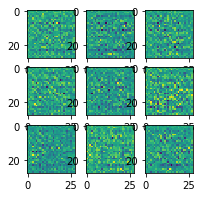

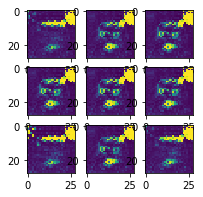

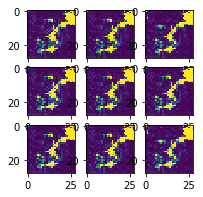

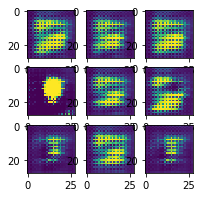

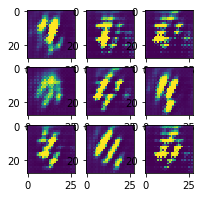

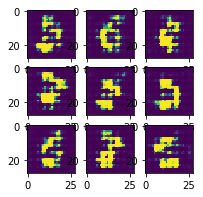

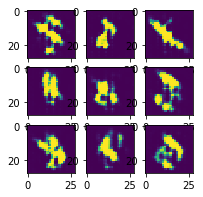

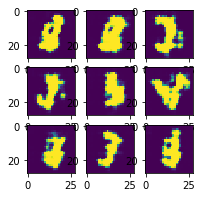

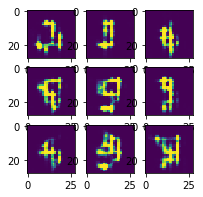

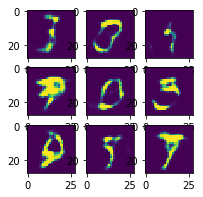

In [12]:
sess.run(tf.global_variables_initializer())
epochs = 10
batches_per_epoch = len(mnist.train.images) // batch_size

g_losses = []
d_losses = []

for epoch_i in range(epochs):
    batch_z = np.random.uniform(-1, 1, size=(9, z_dim))
    gen_im = sess.run(generator(z, n_channels, is_train=False), feed_dict={z: batch_z})
    show_images(gen_im)
    for _ in range(batches_per_epoch):
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        real_im = mnist.train.next_batch(batch_size)[0].reshape((-1,28,28, n_channels))
        
        d_l, _ = sess.run([d_loss, d_trainer], feed_dict={images: 2*(real_im-0.5), z: batch_z})
        g_l, _ = sess.run([g_loss, g_trainer], feed_dict={images: 2*(real_im-0.5), z: batch_z})
        
        g_losses.append(g_l)
        d_losses.append(d_l)
    

---